In [22]:
%pip install -e ..
# %pip install scanpy
%pip install plotly
%pip install ipywidgets
%pip install nbformat
%pip install -U jupyter

Obtaining file:///Users/arjunraj/code/SGanalysis
  Preparing metadata (setup.py) ... done
  Attempting uninstall: SGanalysis
    Found existing installation: SGanalysis 0.1.0
    Uninstalling SGanalysis-0.1.0:
      Successfully uninstalled SGanalysis-0.1.0
  Running setup.py develop for SGanalysis
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from SGanalysis.SGobject import SGobject


In [2]:
# Replace 'path_to_your_tiff_file.tif' with the actual path to your TIFF file
tiff_path = 'segment_20231115_nuclei.tiff'

In [3]:
from SGanalysis.SGobject import SGobject

# Create an instance of SGobject
sg_obj = SGobject()

# Convert a TIFF image to polygons and store them in a GeoDataFrame
print("Running mask_to_objects...")
sg_obj.mask_to_objects('/Users/arjunraj/code/convert_masks_SG/segment_20231115_nuclei.tiff')


Running mask_to_objects...


KeyboardInterrupt: 

In [4]:
sg_obj2 = SGobject()

# Convert a TIFF image to polygons and store them in a GeoDataFrame
print("Running mask_to_objects...")
sg_obj2.mask_to_objects('/Users/arjunraj/code/convert_masks_SG/segment_20231115_cells.tiff')

Running mask_to_objects...


In [5]:
print(sg_obj2.gdf.head())

  object_id                                            nucleus
0        28  POLYGON ((17368.000 0.000, 17486.000 0.000, 17...
1        18  POLYGON ((31827.000 0.000, 31979.000 0.000, 31...
2        23  POLYGON ((14546.000 0.000, 14671.000 0.000, 14...
3         1  POLYGON ((0.000 0.000, 0.000 77.000, 12.000 82...
4         9  POLYGON ((31410.000 0.000, 31573.000 0.000, 31...


In [6]:
spot_file = '/Users/arjunraj/code/convert_masks_SG/transcripts_no_segmentation.csv'

sg_obj2.load_points(spot_file)


In [7]:
print(sg_obj2.points_gdf.head())

    name               refid     x   y                 geometry
0  Nupr1  ENSMUSG00000030717    82  91    POINT (82.000 91.000)
1  Nupr1  ENSMUSG00000030717  2551  72  POINT (2551.000 72.000)
2  Nupr1  ENSMUSG00000030717  2441  97  POINT (2441.000 97.000)
3  Nupr1  ENSMUSG00000030717  3022  36  POINT (3022.000 36.000)
4  Nupr1  ENSMUSG00000030717  3187  44  POINT (3187.000 44.000)


In [8]:

sg_obj2.create_cell_gene_table()

# print(sg_obj2.cell_gene_table.head())

4235747 of 10323626 spots (41.0%) assigned to an object.


name       Ada  Add3  Adh6a  Agr2  Ahnak  Aldh1b1  Aldob  Alpi  Ang4  Anxa1  \
object_id                                                                     
1            0     0      0     0      0        0      0     0     0      0   
10           0     0      0     0     23        0      0     0     0      6   
100          0     0      0     0     38        1      1     0     0     36   
1000         4     0      0     0     20        0      0     0     0      0   
10000        0     0      0     0    188        0      1     0     0      0   

name       ...  Tff3  Tm4sf20  Tm4sf4  Tph1  Tuba1a  Txndc5  Vim  Yap1  \
object_id  ...                                                           
1          ...     0        0       0     0       0       0    0     0   
10         ...     0        0       1     0       0       0    0     2   
100        ...     0        0      11     1       0       0    0     0   
1000       ...     0        0       4     0       0       0    0     2   
10

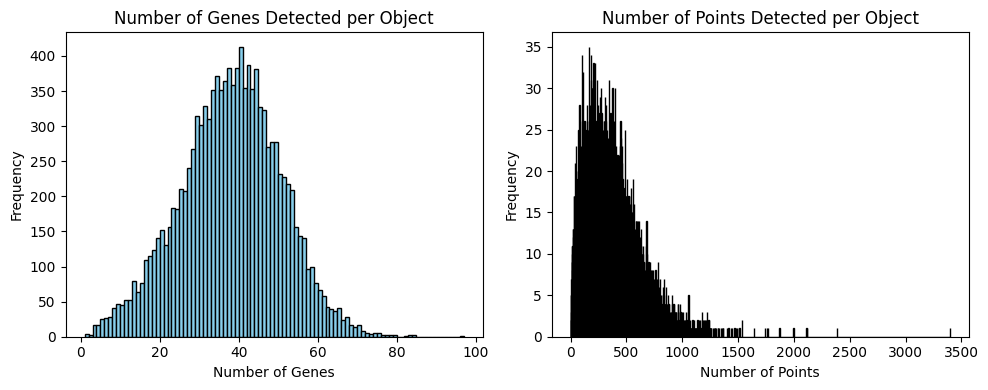

In [9]:
df = sg_obj2.get_cell_gene_table_df()
print(df.head())
sg_obj2.generate_statistics_and_histograms()

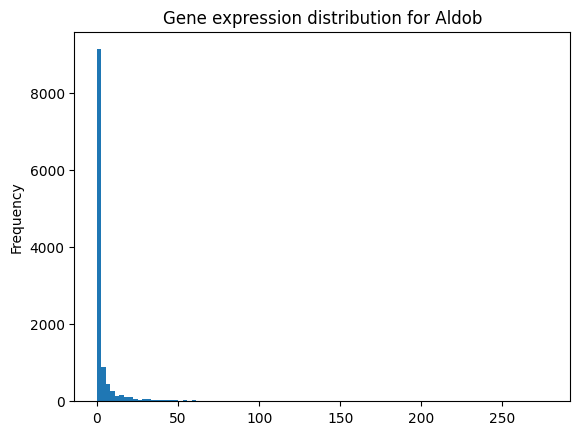

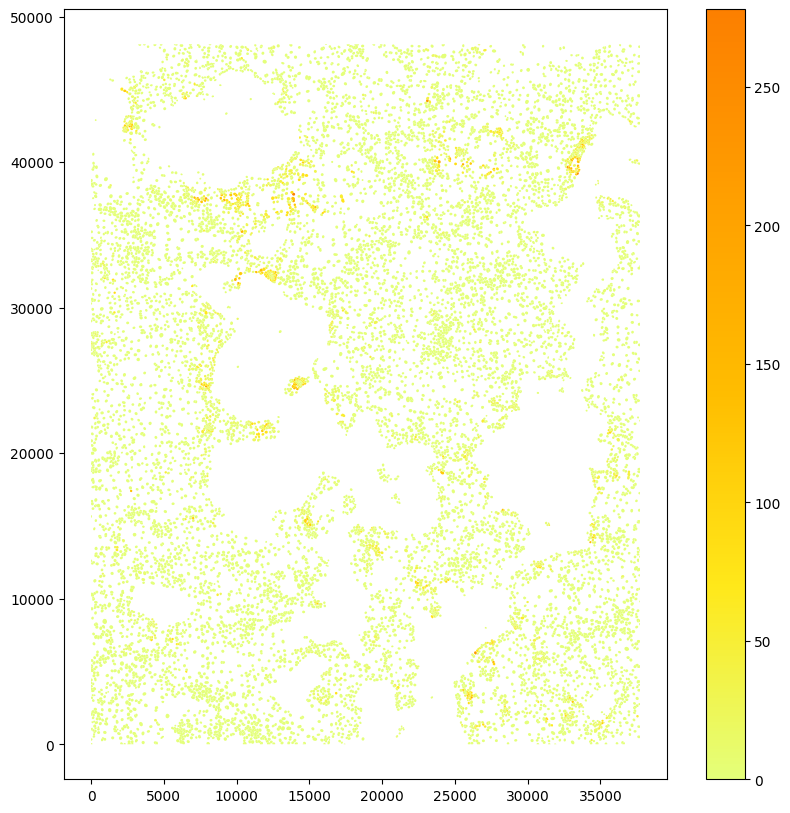

Statistics for gene Aldob: count    12007.000000
mean         5.154243
std         16.147198
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        278.000000
Name: Aldob, dtype: float64
Number of objects expressing Aldob: 4739 out of 12007 (39.47%)


In [10]:
sg_obj2.show_gene_stats_plots("Aldob")

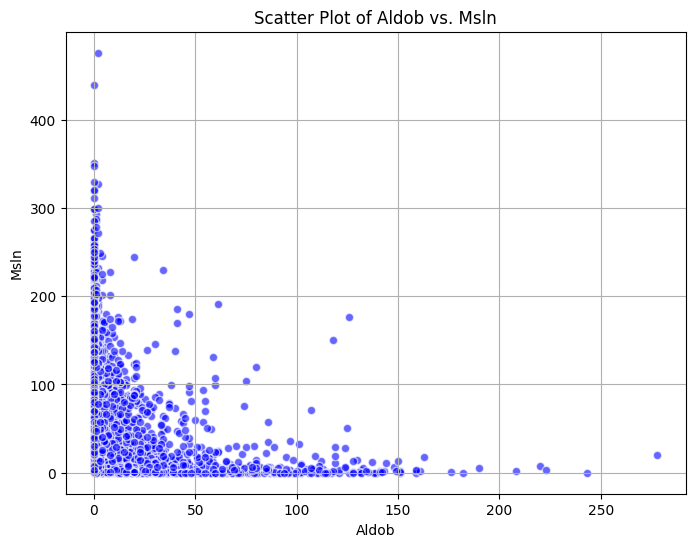

In [11]:
# Plot a scatter of Aldob vs. Lgr5
sg_obj2.plot_gene_scatter("Aldob", "Msln")

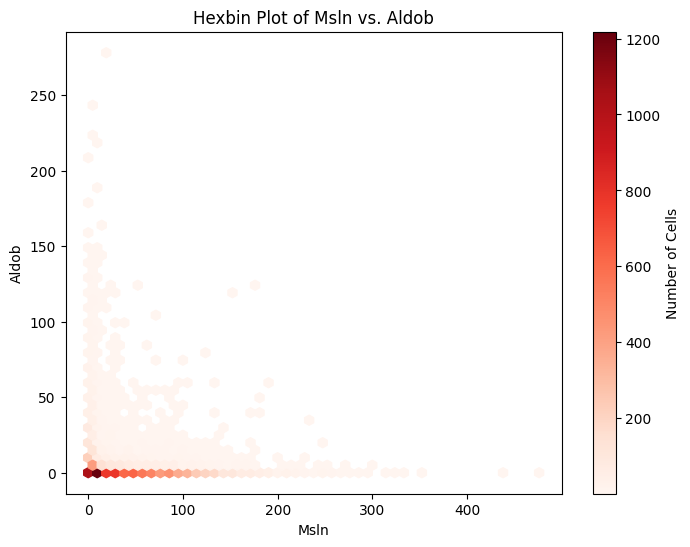

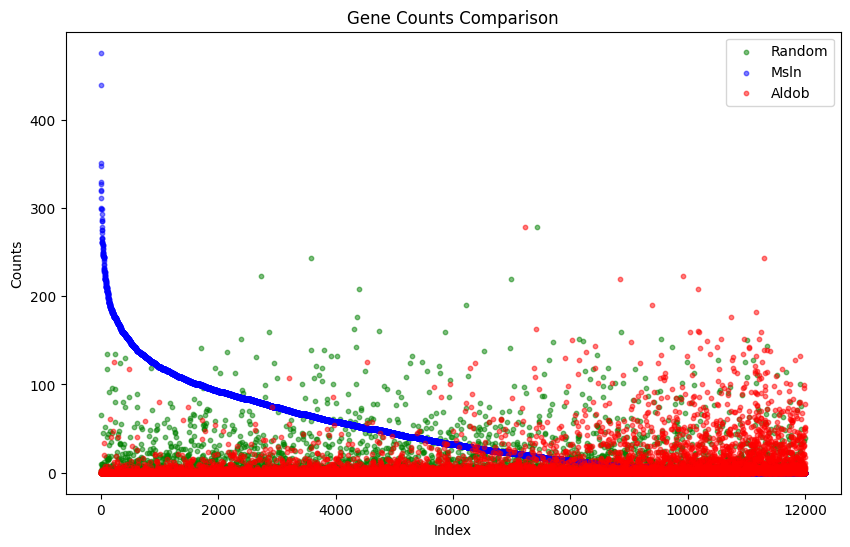

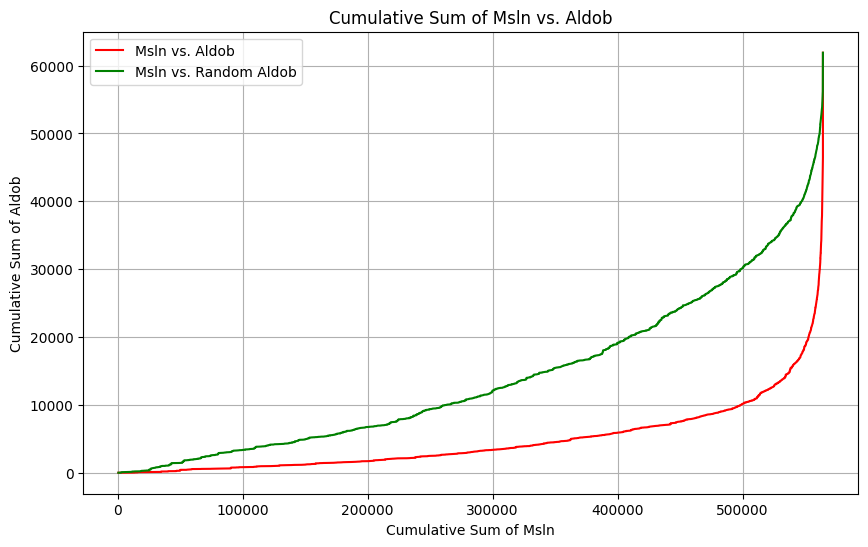

In [12]:
areadiff, totalarea = sg_obj2.l_metric("Msln", "Aldob", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def l_metric(sg_obj, gene1, gene2, plot_hexbin=False, plot_gene_counts=False, plot_cumulative_sum=False):
    cell_count_df = sg_obj.get_cell_gene_table_df()
    gene1_counts = cell_count_df.get(gene1)
    gene2_counts = cell_count_df.get(gene2)

    if plot_hexbin:
        mask = (gene1_counts > 0) | (gene2_counts > 0)
        gene1_counts_nozeros = gene1_counts[mask]
        gene2_counts_nozeros = gene2_counts[mask]
        plt.figure(figsize=(8, 6))
        plt.hexbin(gene1_counts_nozeros, gene2_counts_nozeros, gridsize=50, cmap='Reds', mincnt=1)
        plt.colorbar(label='Number of Cells')
        plt.title(f"Hexbin Plot of {gene1} vs. {gene2}")
        plt.xlabel(gene1)
        plt.ylabel(gene2)
        plt.show()

    df_genes = cell_count_df[[gene1, gene2]].copy()
    df_genes[f"random_{gene2}"] = np.random.permutation(df_genes[gene2].values)
    df_sorted = df_genes.sort_values(by=gene1, ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)

    if plot_gene_counts:
        plt.figure(figsize=(10, 6))
        x_values = df_sorted.index
        plt.scatter(x_values, df_sorted[f"random_{gene2}"], color='green', label="Random", s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene1], color='blue', label=gene1, s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene2], color='red', label=gene2, s=10, alpha=0.5)
        plt.title('Gene Counts Comparison')
        plt.xlabel('Index')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()

    df_sorted['cumsum_' + gene1] = df_sorted[gene1].cumsum()
    df_sorted['cumsum_' + gene2] = df_sorted[gene2].cumsum()
    df_sorted['cumsum_random_' + gene2] = df_sorted[f"random_{gene2}"].cumsum()

    if plot_cumulative_sum:
        plt.figure(figsize=(10, 6))
        plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_' + gene2], color='red', label=f'{gene1} vs. {gene2}')
        plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_random_' + gene2], color='green', label=f'{gene1} vs. Random {gene2}')
        plt.title(f'Cumulative Sum of {gene1} vs. {gene2}')
        plt.xlabel(f'Cumulative Sum of {gene1}')
        plt.ylabel(f'Cumulative Sum of {gene2}')
        plt.grid(True)
        plt.legend()
        plt.show()

    area_difference = 0
    total_area = 0
    for i in range(len(df_sorted) - 1):
        deltaX = df_sorted['cumsum_' + gene1].iloc[i+1] - df_sorted['cumsum_' + gene1].iloc[i]
        deltaY = ((df_sorted['cumsum_' + gene2].iloc[i+1] - df_sorted['cumsum_random_' + gene2].iloc[i+1]) + (df_sorted['cumsum_' + gene2].iloc[i] - df_sorted['cumsum_random_' + gene2].iloc[i])) / 2
        area_difference += deltaX * deltaY
        total_area += deltaX * (df_sorted['cumsum_' + gene2].iloc[i] + df_sorted['cumsum_' + gene2].iloc[i+1])/2

    area_difference_normalized = area_difference / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])
    total_area_normalized = total_area / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])
    return area_difference_normalized, total_area_normalized


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sg_obj2 is defined and l_metric function is available

def compute_pairwise_areadiff(sg_obj, gene_list):
    n = len(gene_list)
    areadiff_matrix = np.zeros((n, n))  # Initialize a square matrix
    totalarea_matrix = np.zeros((n, n))  # Initialize a square matrix

    # Compute pairwise area_difference
    for i, gene1 in enumerate(gene_list):
        for j, gene2 in enumerate(gene_list):
            if i == j:
                areadiff_matrix[i, j] = 0
            else:
                areadiff,totalarea = l_metric(sg_obj, gene1, gene2)
                areadiff_matrix[i, j] = areadiff
                totalarea_matrix[i, j] = totalarea

    return areadiff_matrix, totalarea_matrix

# gene_names = ["Alpi", "Clu", "Sis"]
# areadiff_matrix = compute_pairwise_areadiff(sg_obj2, gene_names)


In [21]:
def plot_heatmap(matrix, labels):
    # Use diverging color map: red for positive, blue for negative, white for zero
    sns.set_theme(font_scale=0.7)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap=cmap, center=0, xticklabels=labels, yticklabels=labels)
    plt.title("Pairwise Area Difference Heatmap")
    plt.show()

# plot_heatmap(areadiff_matrix, gene_names)


In [34]:
# areadiff = l_metric(sg_obj2, "Alpi", "Clu", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)
areadiff,totalarea = l_metric(sg_obj2, "Msln", "Aldob")
print(f"Area Difference: {areadiff}, Total Area: {totalarea}")
#print(areadiff)

Area Difference: -0.15156928834469738, Total Area: 0.07611705342393066


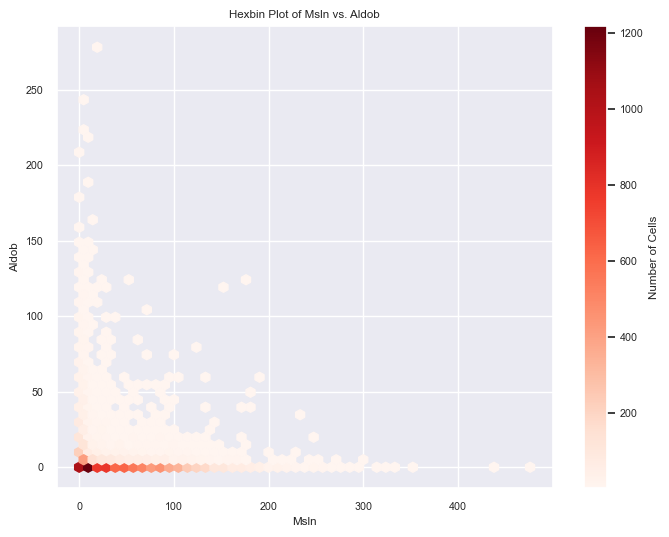

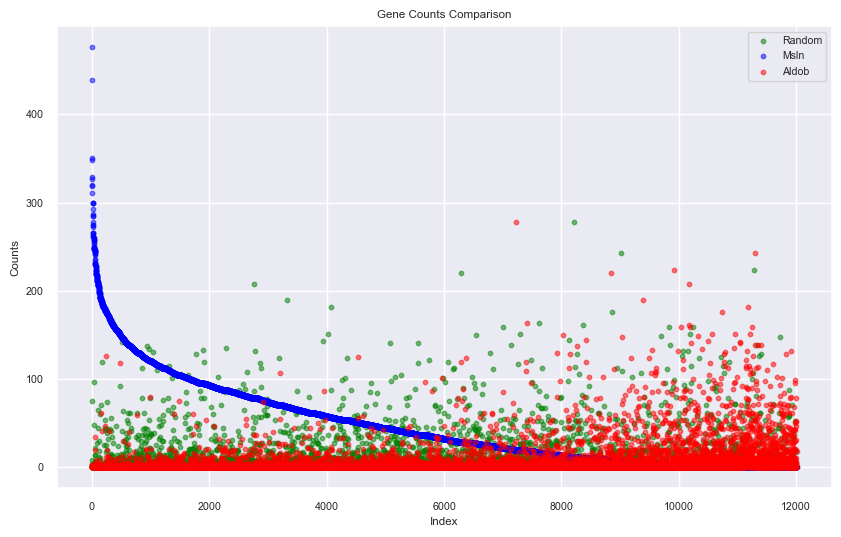

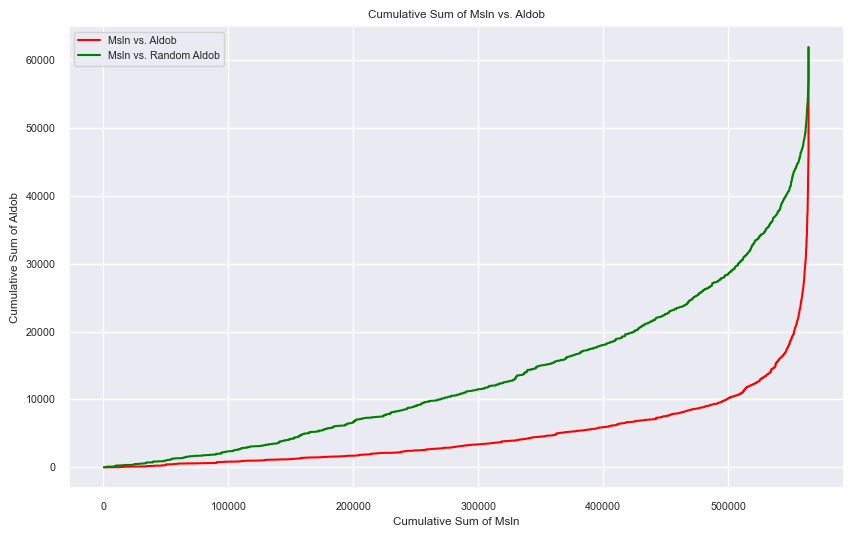

In [43]:
areadiff, totalarea = l_metric(sg_obj2, "Msln", "Aldob", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


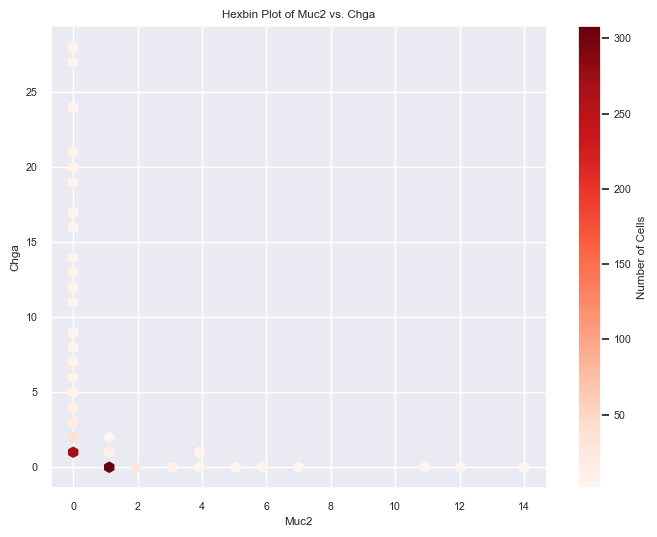

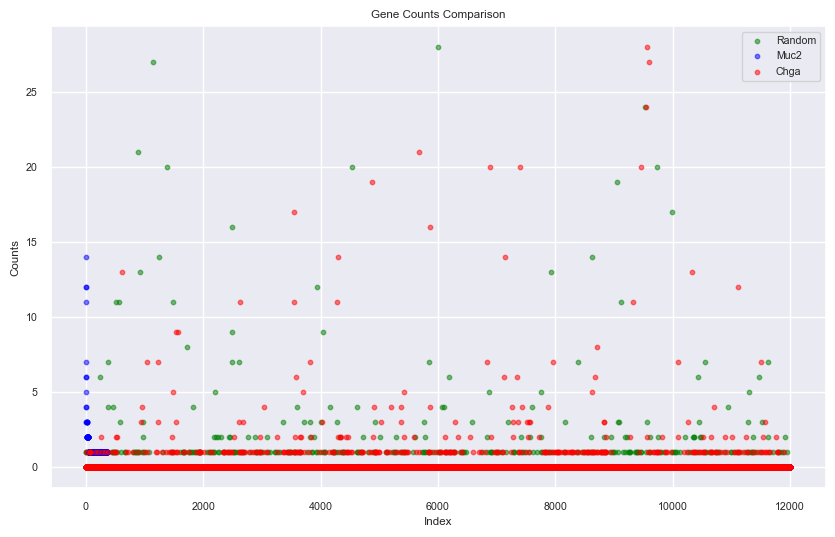

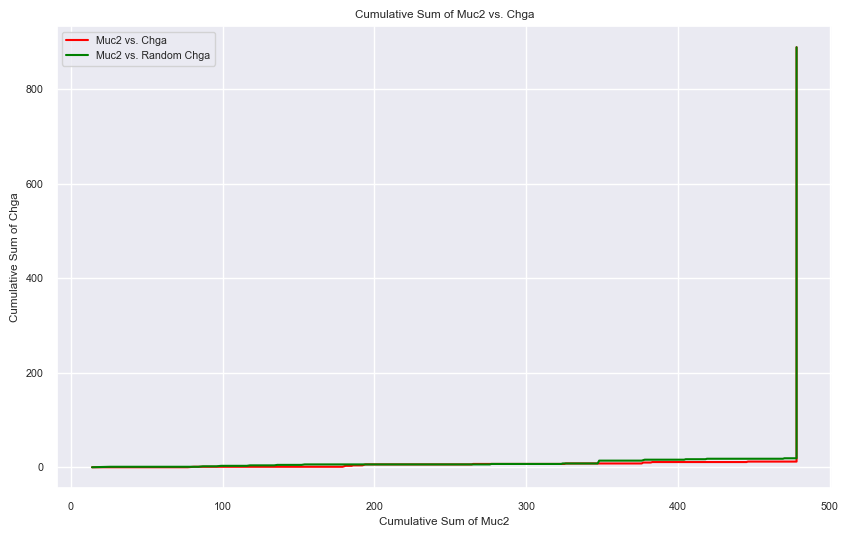

In [45]:
areadiff, totalarea = l_metric(sg_obj2, "Muc2", "Chga", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


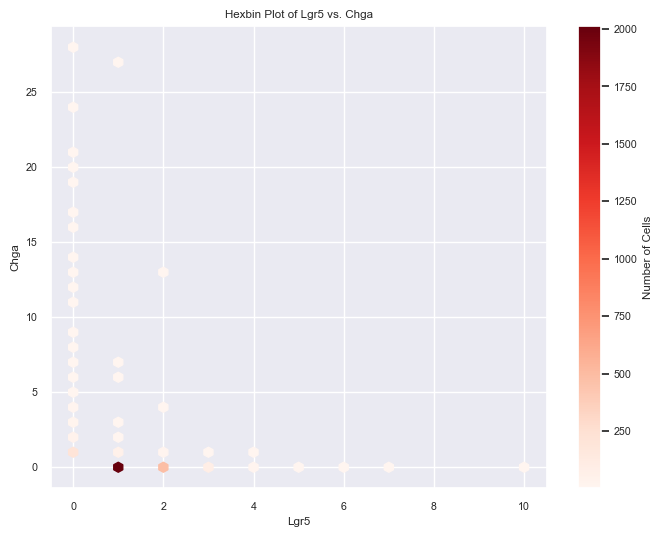

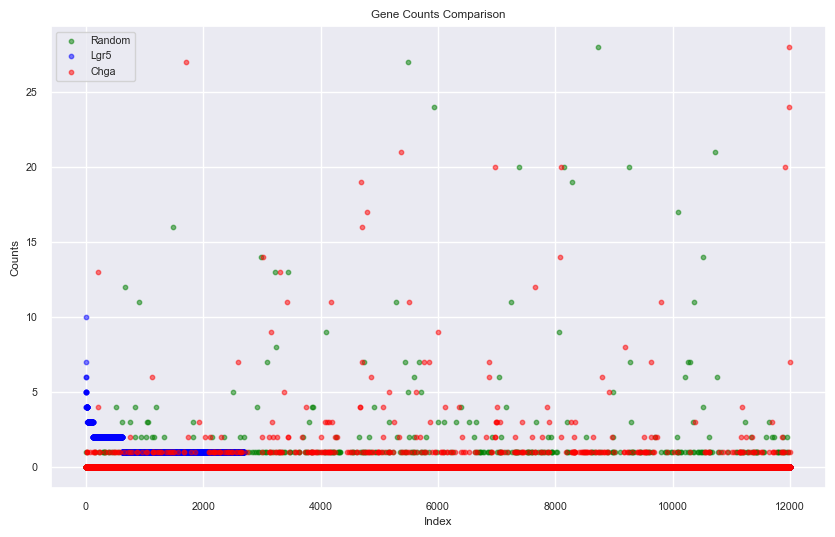

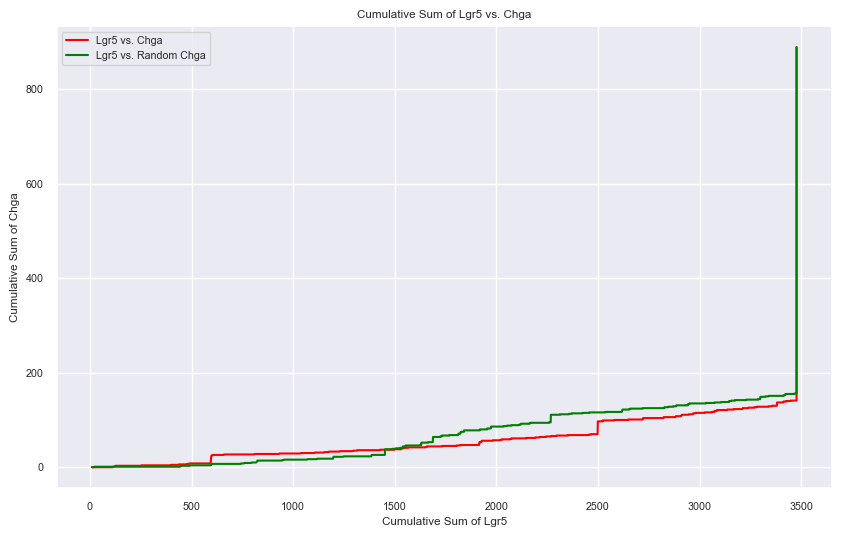

In [42]:
areadiff, totalarea = l_metric(sg_obj2, "Lgr5", "Chga", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


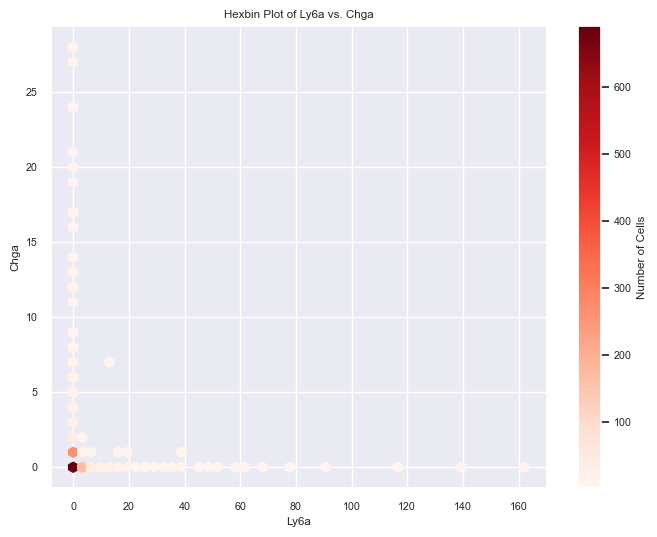

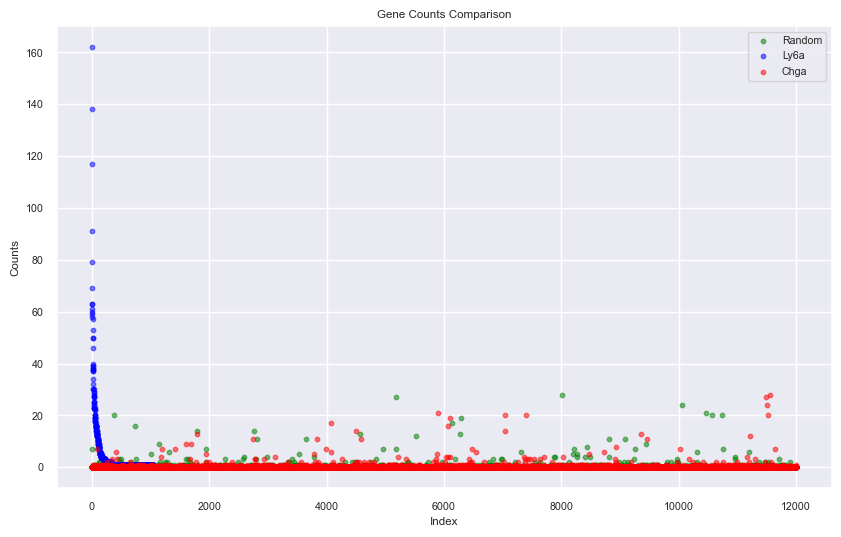

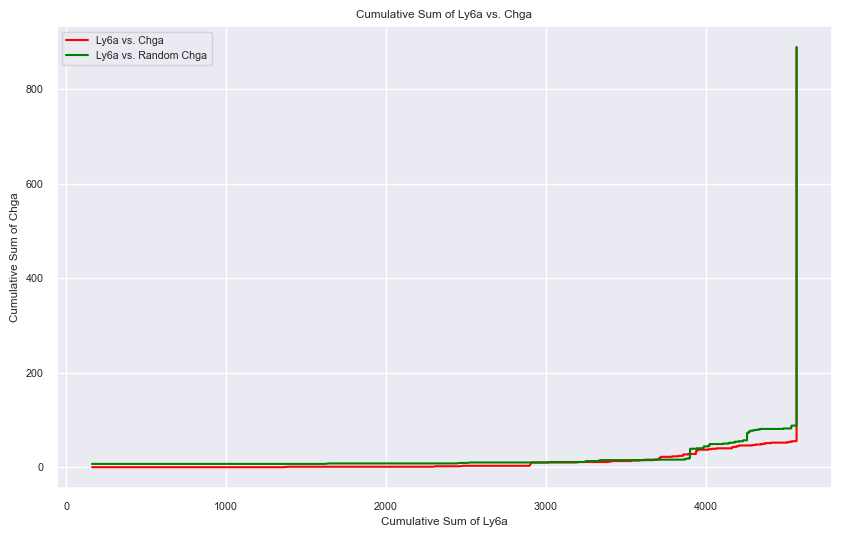

In [46]:
areadiff, totalarea = l_metric(sg_obj2, "Ly6a", "Chga", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


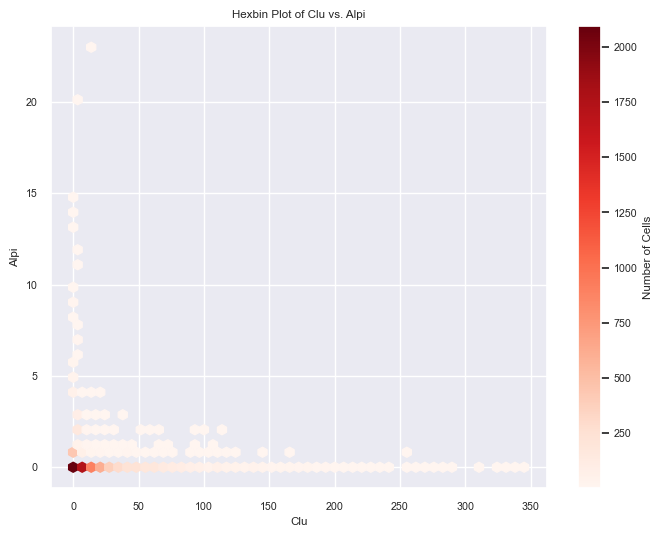

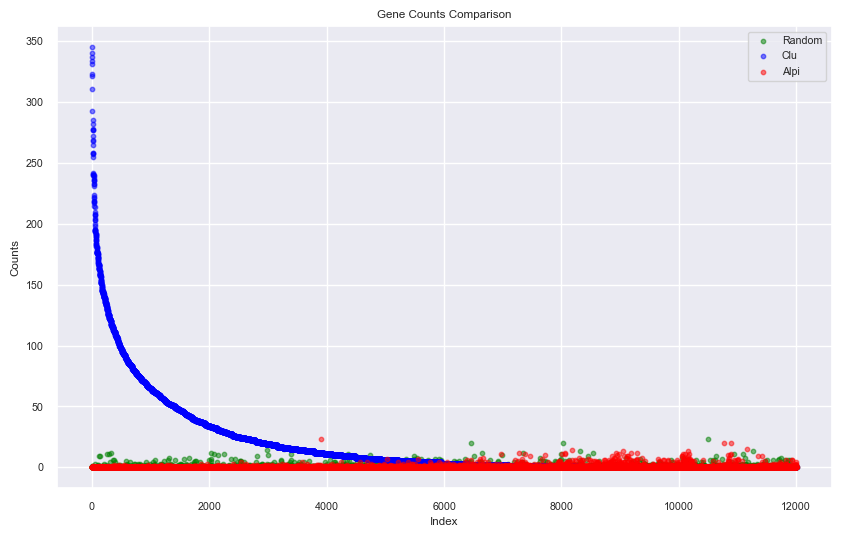

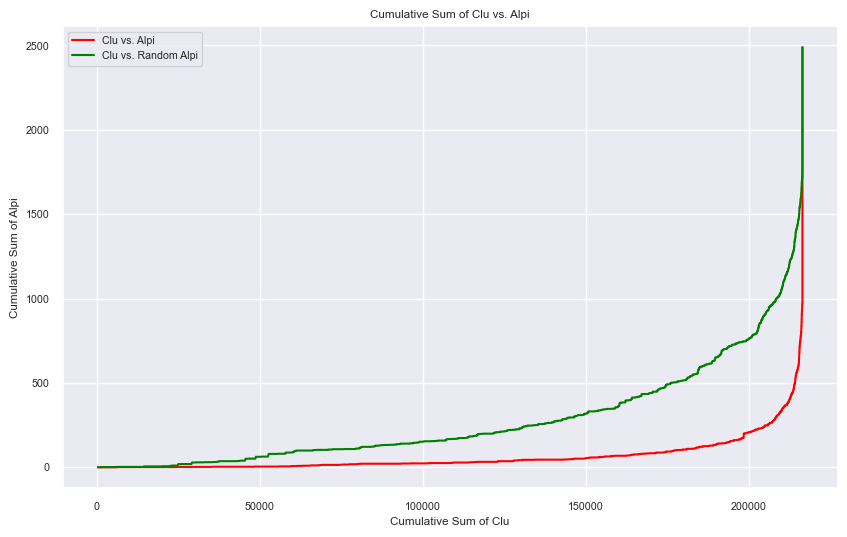

In [47]:
areadiff, totalarea = l_metric(sg_obj2, "Clu", "Alpi", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


In [ ]:
areadiff, totalarea = l_metric(sg_obj2, "Muc2", "Chga", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


In [44]:
paneth = ['Lyz1']
goblet = ['Muc2']
eec = [ 'Chga']
Tuft = ['Dclk1']
Stem = ['Olfm4', 'Lgr5']
enterocyte = ['Alpi', 'Aldob', 'Apoa1', 'Apoa4', 'Sis']
revival = ['Clu', 'Ly6a', 'Msln']

full_gene_list = paneth + goblet + eec + Tuft + Stem + enterocyte + revival
areadiff_matrix,totalarea_matrix = compute_pairwise_areadiff(sg_obj2, full_gene_list)


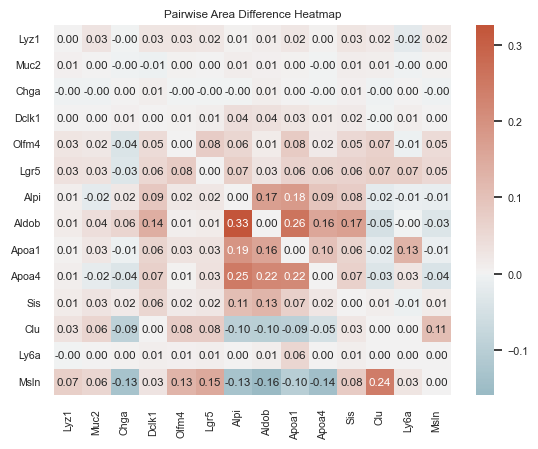

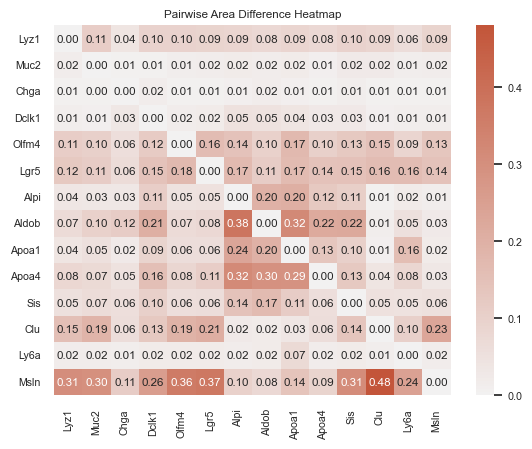

In [41]:
plot_heatmap(areadiff_matrix, full_gene_list)
plot_heatmap(totalarea_matrix, full_gene_list)

In [8]:
areadiff, totalarea = l_metric(sg_obj2, "Msln", "Dclk1", plot_hexbin=True, plot_gene_counts=True, plot_cumulative_sum=True)


NameError: name 'l_metric' is not defined

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Polygon
from ipywidgets import interactive

# Generate random data
np.random.seed(42)
num_polygons = 30
data = {
    'var1': np.random.rand(num_polygons) * 100,
    'var2': np.random.rand(num_polygons) * 100,
    'geometry': [Polygon([(np.random.rand() * 2, np.random.rand() * 2),
                          (np.random.rand() * 2, np.random.rand() * 2 + 1),
                          (np.random.rand() * 2 + 1, np.random.rand() * 2 + 1),
                          (np.random.rand() * 2 + 1, np.random.rand() * 2)]) for _ in range(num_polygons)]
}
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Plotting function to update based on selection
def plot_selected_data(selected_indices):
    if selected_indices is None:
        selected_indices = []
    
    # Highlight selected polygons
    selected_gdf = gdf.iloc[selected_indices]
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(ax=ax, color='lightblue', edgecolor='black')
    selected_gdf.plot(ax=ax, color='red', edgecolor='black')
    plt.show()

# Interactive scatter plot using Plotly
def interactive_scatter():
    fig = px.scatter(gdf, x='var1', y='var2', title="Select Points from Scatter Plot")
    scatter_widget = fig.data[0]

    def selection_fn(trace, points, selector):
        plot_selected_data(points.point_inds)

    scatter_widget.on_selection(selection_fn)
    fig.show()

interactive_scatter()


In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Polygon
from ipywidgets import widgets, Output
from IPython.display import display

# Generate random data
np.random.seed(42)
num_polygons = 30
data = {
    'var1': np.random.rand(num_polygons) * 100,
    'var2': np.random.rand(num_polygons) * 100,
    'geometry': [Polygon([(np.random.rand() * 2, np.random.rand() * 2),
                          (np.random.rand() * 2, np.random.rand() * 2 + 1),
                          (np.random.rand() * 2 + 1, np.random.rand() * 2 + 1),
                          (np.random.rand() * 2 + 1, np.random.rand() * 2)]) for _ in range(num_polygons)]
}
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Ensure the CRS is appropriate for plotting (change as needed)
gdf = gdf.to_crs(epsg=3857)  # Web Mercator

# Plotting function to update based on selection
def plot_selected_data(selected_indices):
    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot all polygons with light blue color
    gdf.plot(ax=ax, color='lightblue', edgecolor='black')
    # Highlight selected polygons with red color
    if selected_indices:
        gdf.iloc[selected_indices].plot(ax=ax, color='red', edgecolor='black')
    plt.show()

# Function to handle selection from scatter plot
def selection_handler(trace, points, selector):
    # Print the indices of the selected points to verify the function is triggered
    print("Selected indices:", points.point_inds)
    # Call the plot function to update the map with selected data
    plot_selected_data(points.point_inds)


# Plotly scatter plot
def interactive_scatter():
    fig = px.scatter(gdf, x='var1', y='var2', title="Select Points from Scatter Plot")
    scatter_plot = fig.data[0]
    scatter_plot.on_selection(selection_handler)
    fig.show()

interactive_scatter()


In [5]:
import plotly.io as pio
pio.renderers
pio.renderers.default = 'notebook_connected'

In [7]:
import plotly.express as px
import pandas as pd
import numpy as np

# Create sample data
df = pd.DataFrame({
    'var1': np.random.rand(100) * 100,
    'var2': np.random.rand(100) * 100
})

# Create a scatter plot
fig = px.scatter(df, x='var1', y='var2', title="Interactive Scatter Plot")

# Function to handle selection events
def selection_handler(trace, points, selector):
    print("Selection handler triggered")
    print("Selected indices:", points.point_inds)

# Bind the selection event to the handler
fig.data[0].on_selection(selection_handler)

print("Starting...")

fig.show()


Starting...


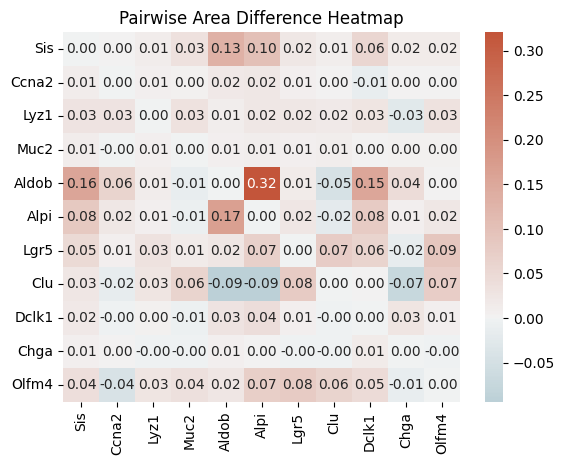

In [144]:
gene_list = {"Alpi","Sis","Aldob","Olfm4","Lgr5","Chga","Dclk1","Lyz1","Muc2","Clu","Ccna2"}
areadiff_matrix = compute_pairwise_areadiff(sg_obj2, gene_list)
plot_heatmap(areadiff_matrix, gene_list)

Kept 8917 out of 12007 objects


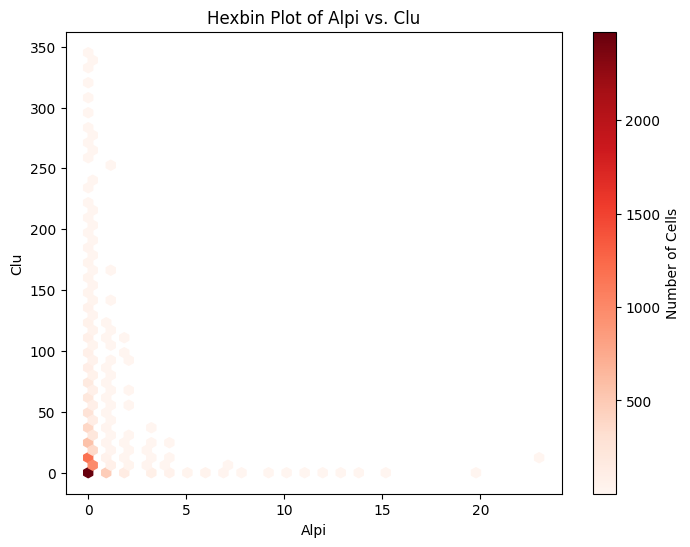

Kendall's Tau (remove zeros): -0.325, p-value: 0.000
Kendall's Tau (keep zeros): -0.156, p-value: 0.000


In [112]:
# gene1 = "Ly6a"
# gene2 = "Olfm4"
# gene1 = "Olfm4"
# gene2 = "Ly6a"
# gene1 = "Alpi"
# gene2 = "Clu"
gene1 = "Clu"
gene2 = "Alpi"
# gene1 = "Ccna2"
# gene2 = "Aldob"
# gene1 = "Aldob"
# gene2 = "Alpi"
gene1 = "Mki67"
gene2 = "Alpi"
gene1 = "Alpi"
gene2 = "Clu"
cell_count_df = sg_obj2.get_cell_gene_table_df()
gene1_counts = cell_count_df.get(gene1)
gene2_counts = cell_count_df.get(gene2)

# Only keep objects for which either gene1 or gene2 has a value > 0
mask = (gene1_counts > 0) | (gene2_counts > 0)
print("Kept {} out of {} objects".format(mask.sum(), len(mask)))
gene1_counts = gene1_counts[mask]
gene2_counts = gene2_counts[mask]


plt.figure(figsize=(8, 6))
plt.hexbin(gene1_counts, gene2_counts, gridsize=50, cmap='Reds', mincnt=1)
plt.colorbar(label='Number of Cells')
plt.title(f"Hexbin Plot of {gene1} vs. {gene2}")
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.show()

from scipy.stats import kendalltau

tau, p_value = kendalltau(gene1_counts, gene2_counts)
print(f"Kendall's Tau (remove zeros): {tau:.3f}, p-value: {p_value:.3f}")

gene1_counts = cell_count_df.get(gene1)
gene2_counts = cell_count_df.get(gene2)
tau, p_value = kendalltau(gene1_counts, gene2_counts)
print(f"Kendall's Tau (keep zeros): {tau:.3f}, p-value: {p_value:.3f}")


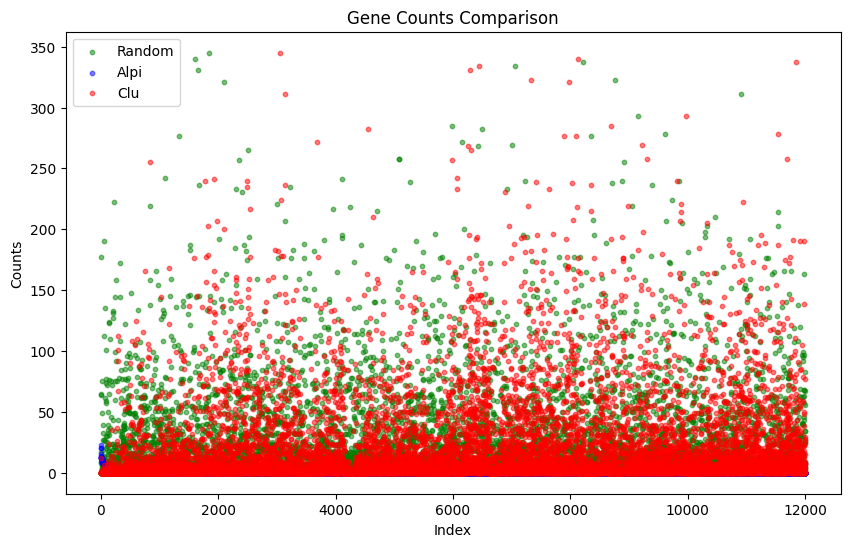

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have a DataFrame named df with columns 'gene1' and 'gene2'
# df = pd.DataFrame(...)  # Your existing DataFrame

# Create a new DataFrame with just 'gene1' and 'gene2' columns
df_genes = cell_count_df[[gene1, gene2]].copy()

# Adding a new column with random integer values between 0 and 50
# Assuming the length of your DataFrame is len(df_genes)
df_genes['random'] = np.random.randint(0, 51, size=len(df_genes))

# Create a new column 'random_gene2' with a random shuffling of 'gene2' column
df_genes[f"random_{gene2}"] = np.random.permutation(df_genes[gene2].values)


# Sort the DataFrame based on 'gene1' in descending order
df_sorted = df_genes.sort_values(by=gene1, ascending=False)

# Reset the index of the sorted DataFrame (optional, for cleaner x-axis values in the plot)
df_sorted.reset_index(drop=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
x_values = df_sorted.index  # X values are the indices of the sorted DataFrame
plt.scatter(x_values, df_sorted[f"random_{gene2}"], color='green', label="Random", s=10, alpha=0.5)
plt.scatter(x_values, df_sorted[gene1], color='blue', label=gene1, s=10, alpha=0.5)
plt.scatter(x_values, df_sorted[gene2], color='red', label=gene2, s=10, alpha=0.5)
plt.title('Gene Counts Comparison')
plt.xlabel('Index')
plt.ylabel('Counts')
plt.legend()
plt.show()


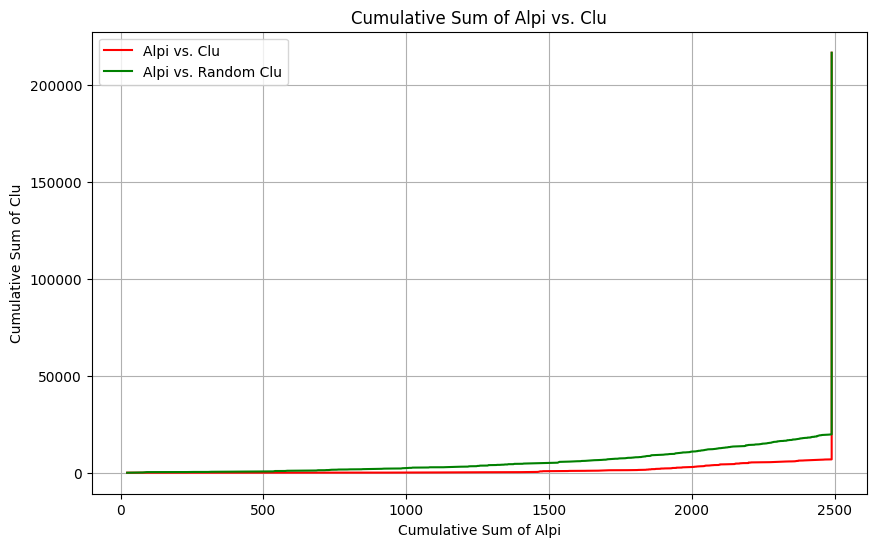

Area Difference: -10510708.5
Area Difference Normalized: -0.019507578319730733


In [114]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the cumulative sum for each column
df_sorted['cumsum_' + gene1] = df_sorted[gene1].cumsum()
df_sorted['cumsum_' + gene2] = df_sorted[gene2].cumsum()
df_sorted['cumsum_' + "random_{gene2}"] = df_sorted[f"random_{gene2}"].cumsum()

# Plotting the cumulative sums against each other
plt.figure(figsize=(10, 6))

plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_' + gene2], color='red', label=f'{gene1} vs. {gene2}')
plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_' + "random_{gene2}"], color='green', label=f'{gene1} vs. Random {gene2}')
plt.title(f'Cumulative Sum of {gene1} vs. {gene2}')
plt.xlabel(f'Cumulative Sum of {gene1}')
plt.ylabel(f'Cumulative Sum of {gene2}')
plt.grid(True)
plt.legend()
plt.show()

area_difference = 0

for i in range(len(df_sorted) - 1):
    # Could, for the next line, also just use the original value of gene1 instead of the difference in the cumulative sum
    deltaX = df_sorted['cumsum_' + gene1].iloc[i+1] - df_sorted['cumsum_' + gene1].iloc[i]
    deltaY = ((df_sorted['cumsum_' + gene2].iloc[i+1] - df_sorted['cumsum_' + "random_{gene2}"].iloc[i+1]) + (df_sorted['cumsum_' + gene2].iloc[i] - df_sorted['cumsum_' + "random_{gene2}"].iloc[i]))/2
    area_difference += deltaX * deltaY

area_difference_normalized = area_difference / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])
print("Area Difference:", area_difference)
print("Area Difference Normalized:", area_difference_normalized)

# area_difference2 = 0

# for i in range(len(df_sorted) - 1):
#     deltaX = df_sorted[gene1].iloc[i]
#     deltaY = df_sorted[gene2].iloc[i] - df_sorted['random_' + gene2].iloc[i]
#     area_difference2 += deltaX * deltaY

# area_difference_normalized2 = area_difference2 / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])

# print("Area Difference from derivative:", area_difference2)
# print("Area Difference Normalized from derivative:", area_difference_normalized2)

# print("cumsum gene1", df_sorted['cumsum_' + gene1].iloc[-1])
# print("cumsum gene2", df_sorted['cumsum_' + gene2].iloc[-1])

In [99]:
sg_obj.load_points(spot_file)
sg_obj.create_cell_count_df()
print(sg_obj.cell_count_df.head())

NameError: name 'sg_obj' is not defined

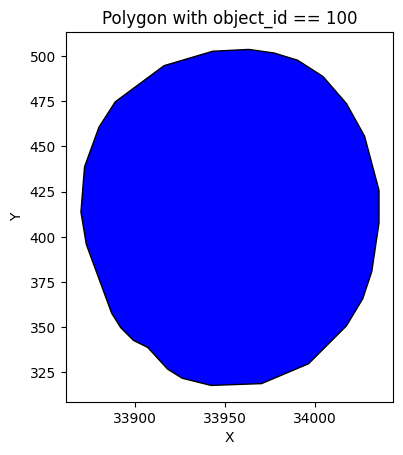

In [8]:
sg_obj2.plot_polygon_by_id(100)

/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:233: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(exterior_points.geometry.x, exterior_points.geometry.y, marker='x', s=50, edgecolor='black', color=color_map[name])


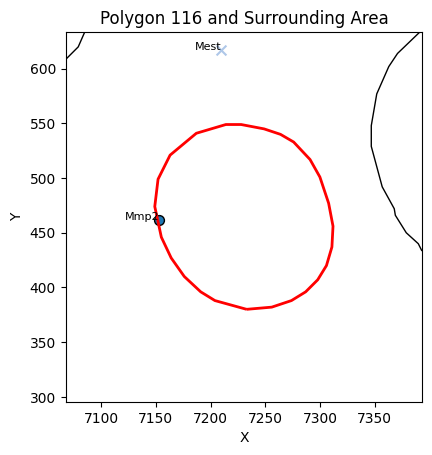

In [16]:
sg_obj2.plot_polygon_and_points(116)

In [11]:
print(sg_obj2.cell_count_df.head())
print(len(sg_obj2.cell_count_df))

name  object_id  Abca7  Aldh1a2  Apoe  Atad2  Atm  Aurkb  Bad  Bax  Bbc3  ...  \
0          13.0      0        0     0      0    0      0    0    0     0  ...   
1          48.0      0        0     1      0    0      0    0    0     0  ...   
2          54.0      0        0     0      0    0      0    0    0     0  ...   
3          89.0      0        0     0      0    0      0    0    0     0  ...   
4         116.0      0        0     0      0    0      0    0    0     0  ...   

name  Ung  Utf1  Vwf  Was  Wnt3a  Wnt5a  Wnt5b  Zeb1  Zeb2  Zfp42  
0       0     0    0    0      0      0      0     0     0      0  
1       0     0    0    0      0      0      0     0     0      0  
2       0     0    0    0      0      0      0     0     0      0  
3       0     0    0    0      0      0      0     0     0      0  
4       0     0    0    0      0      0      0     0     0      0  

[5 rows x 222 columns]
547


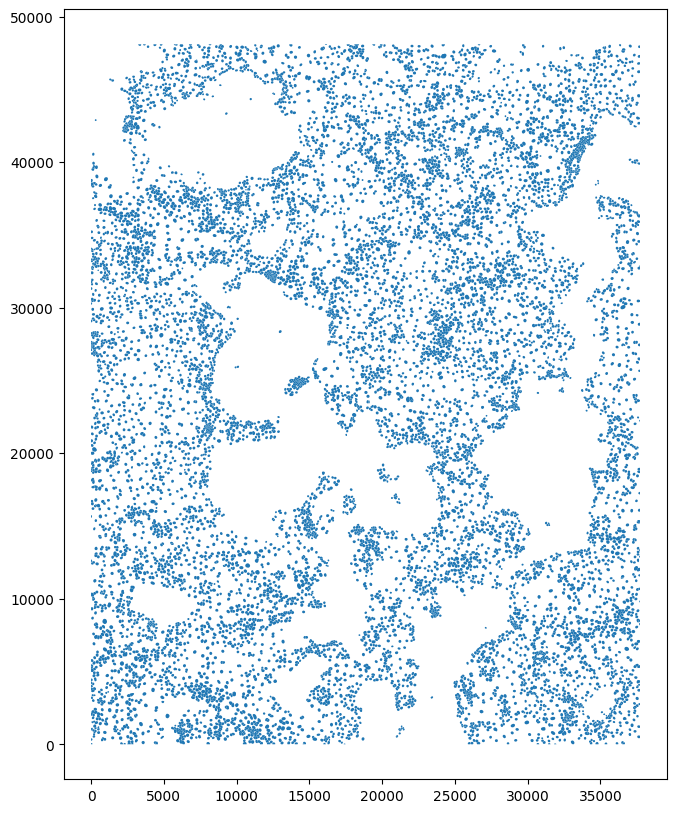

In [5]:
sg_obj2.gdf.plot(figsize=(10, 10))
plt.show()

In [8]:
sg_obj2.points_gdf.plot(figsize=(10, 10))
plt.show()
print(sg_obj2.points_gdf.head())

NameError: name 'sg_obj2' is not defined

In [34]:
# print the minimum and maximum values of the x and y coordinates for sg_obj2.points_gdf
print(sg_obj2.points_gdf['x'].min(), sg_obj2.points_gdf['x'].max())
print(sg_obj2.points_gdf['y'].min(), sg_obj2.points_gdf['y'].max())
print(len(sg_obj2.points_gdf))

20 9915
44 10435
845413


CAT DATA******************************
**************************************
**************************************

In [13]:
# Now try the JSON file and working with Cat's data

json_file = '/Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation.json'
sg_obj3 = SGobject()
sg_obj3.nimbus_json_to_objects(json_file)
print(sg_obj3.gdf.head())

                  object_id                                            nucleus
0  65d3a2a53f73fc2469cc3ab5  POLYGON ((4972.000 1802.000, 4936.000 1826.000...
1  65d3a2a53f73fc2469cc3ab6  POLYGON ((4789.000 1823.000, 4768.000 1828.000...
2  65d3a2a53f73fc2469cc3ab7  POLYGON ((5110.000 1854.000, 5078.000 1859.000...
3  65d3a2a53f73fc2469cc3ab8  POLYGON ((4368.000 1903.000, 4360.000 1906.000...
4  65d3a2a53f73fc2469cc3ab9  POLYGON ((4837.000 1911.000, 4815.000 1917.000...


In [14]:
# OK, now going to look for centroid distance to find neighbors. Testing some code options here.

gdf = sg_obj3.gdf

gdf['centroid'] = gdf.geometry.centroid

print(gdf.head())

                  object_id  \
0  65d3a2a53f73fc2469cc3ab5   
1  65d3a2a53f73fc2469cc3ab6   
2  65d3a2a53f73fc2469cc3ab7   
3  65d3a2a53f73fc2469cc3ab8   
4  65d3a2a53f73fc2469cc3ab9   

                                             nucleus  \
0  POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1  POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2  POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3  POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4  POLYGON ((4837.000 1911.000, 4815.000 1917.000...   

                    centroid  
0  POINT (4959.281 1848.890)  
1  POINT (4771.483 1850.391)  
2  POINT (5088.552 1878.509)  
3  POINT (4372.564 1929.058)  
4  POINT (4836.040 1960.154)  


In [22]:
from scipy.spatial import distance as sci_dist


# Assuming gdf is your GeoDataFrame and it has a column 'centroid' with Point geometries
# Step 1: Extract (x, y) coordinates from the centroids
coords = np.array([(point.x, point.y) for point in gdf['centroid']])

# Step 2: Compute the pairwise distances between centroids
distance = sci_dist.pdist(coords)

# Step 3: Convert the condensed distance matrix to a square form
dist_mat = sci_dist.squareform(distance)

print(dist_mat.shape)

(4330, 4330)


In [25]:
# Example: Find neighbors within a radius of 15 units (e.g., 15 meters or degrees depending on your CRS)
radius = 200

# Buffer the points to create circles with the specified radius, then check for intersections
# Note: The units here depend on your CRS
gdf['geometry_buffered'] = gdf.buffer(radius)

# Initialize a column to store neighbors
gdf['neighbors'] = None

for index, row in gdf.iterrows():
    # Intersecting the buffered point with all other points
    neighbors = gdf['geometry_buffered'].intersects(row['geometry_buffered'])
    
    # Exclude the point itself from its neighbors
    neighbors.loc[index] = False
    
    # Save the ids of neighboring points
    gdf.at[index, 'neighbors'] = gdf.loc[neighbors, 'object_id'].tolist()

# Drop the temporary buffered geometry column if no longer needed
gdf = gdf.drop(columns=['geometry_buffered'])

print(gdf)

                     object_id  \
0     65d3a2a53f73fc2469cc3ab5   
1     65d3a2a53f73fc2469cc3ab6   
2     65d3a2a53f73fc2469cc3ab7   
3     65d3a2a53f73fc2469cc3ab8   
4     65d3a2a53f73fc2469cc3ab9   
...                        ...   
4325  65d3a5a73f73fc2469cc5cc5   
4326  65d3a5ae3f73fc2469cc5cc8   
4327  65d3a5b23f73fc2469cc5ccb   
4328  65d3a6143f73fc2469cc5cd8   
4329  65d3a6d83f73fc2469cc5ceb   

                                                nucleus  \
0     POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1     POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2     POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3     POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4     POLYGON ((4837.000 1911.000, 4815.000 1917.000...   
...                                                 ...   
4325  POLYGON ((3965.975 3779.809, 3965.543 3791.461...   
4326  POLYGON ((3874.486 3462.619, 3872.328 3472.545...   
4327  POLYGON ((3924.978 3743.991, 3922.820 3751.327...   
4

In [26]:
gdf['neighbor_count'] = gdf['neighbors'].apply(len)
print(gdf.head())


                  object_id  \
0  65d3a2a53f73fc2469cc3ab5   
1  65d3a2a53f73fc2469cc3ab6   
2  65d3a2a53f73fc2469cc3ab7   
3  65d3a2a53f73fc2469cc3ab8   
4  65d3a2a53f73fc2469cc3ab9   

                                             nucleus  \
0  POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1  POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2  POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3  POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4  POLYGON ((4837.000 1911.000, 4815.000 1917.000...   

                    centroid  \
0  POINT (4959.281 1848.890)   
1  POINT (4771.483 1850.391)   
2  POINT (5088.552 1878.509)   
3  POINT (4372.564 1929.058)   
4  POINT (4836.040 1960.154)   

                                           neighbors  neighbor_count  
0  [65d3a2a53f73fc2469cc3ab6, 65d3a2a53f73fc2469c...              49  
1  [65d3a2a53f73fc2469cc3ab5, 65d3a2a53f73fc2469c...              39  
2  [65d3a2a53f73fc2469cc3ab5, 65d3a2a53f73fc2469c...              49  

<Axes: >

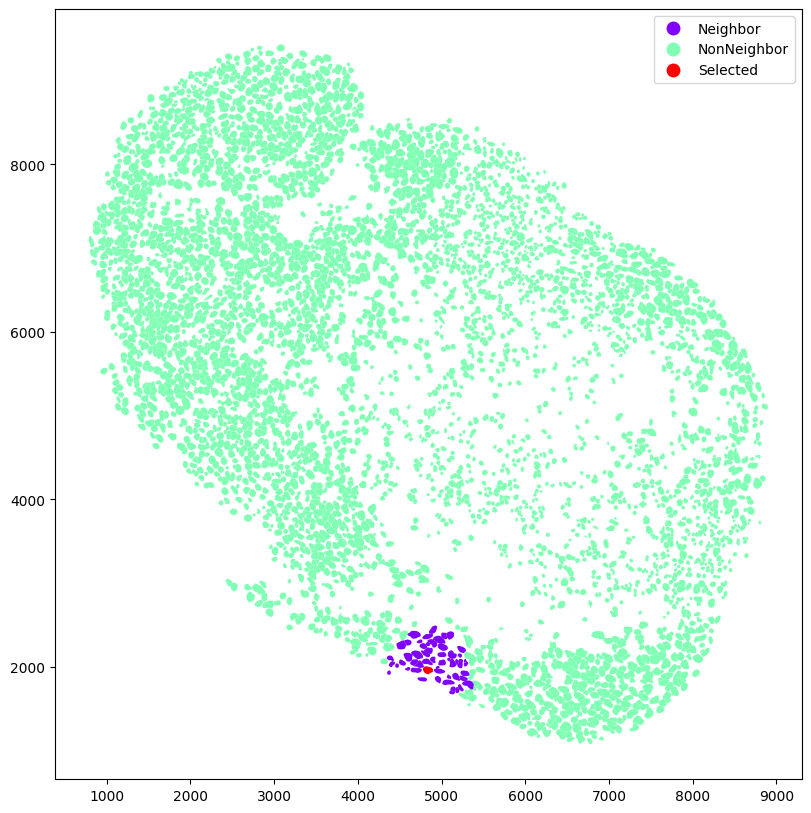

In [32]:
chosen_object_id = '65d3a2a53f73fc2469cc3ab9'  # Replace this with your chosen object_id

# Initialize the new column with default value "NonNeighbor"
gdf['Category'] = 'NonNeighbor'

# Find the index of the chosen object
chosen_index = gdf[gdf['object_id'] == chosen_object_id].index

# If the chosen object exists in the DataFrame
if not chosen_index.empty:
    chosen_index = chosen_index[0]
    
    # Set the category for the chosen object
    gdf.at[chosen_index, 'Category'] = 'Selected'
    
    # Retrieve the list of neighbors for the chosen object
    neighbors = gdf.at[chosen_index, 'neighbors']
    
    # Set the category for each neighbor
    for neighbor_id in neighbors:
        # Find rows that match the neighbor_id, could be more than one row if object_ids are not unique
        neighbor_indexes = gdf[gdf['object_id'] == neighbor_id].index
        gdf.loc[neighbor_indexes, 'Category'] = 'Neighbor'
else:
    print(f"Object ID {chosen_object_id} not found in the DataFrame.")

# Display the updated DataFrame (or perform other operations as needed)
gdf.plot(column='Category', legend=True, figsize=(10, 10), cmap='rainbow')

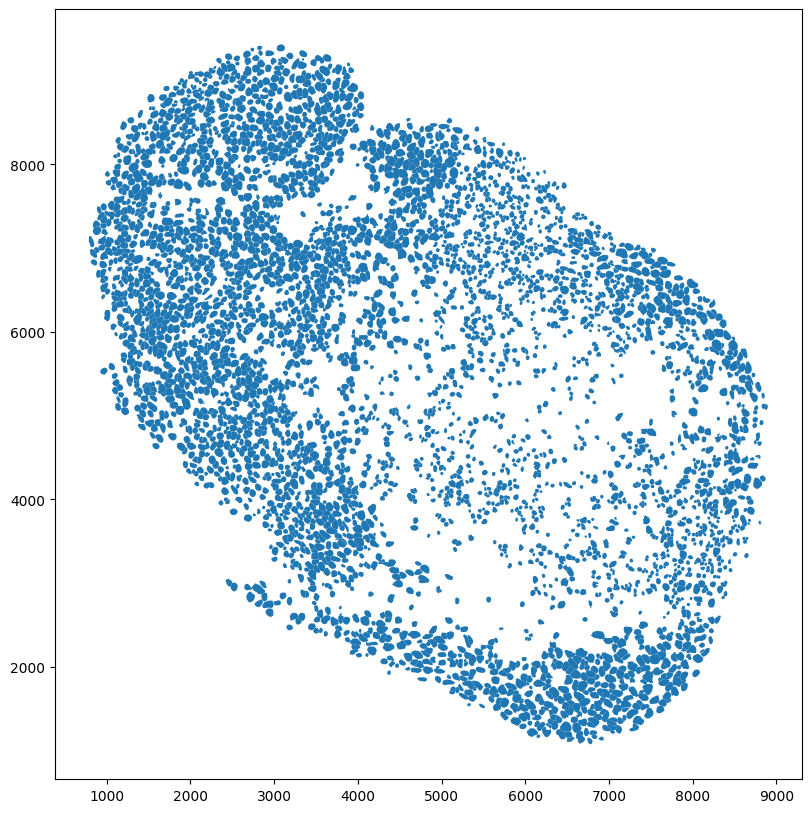

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
sg_obj3.gdf.plot(ax=ax)
ax.set_aspect('equal')
plt.show()

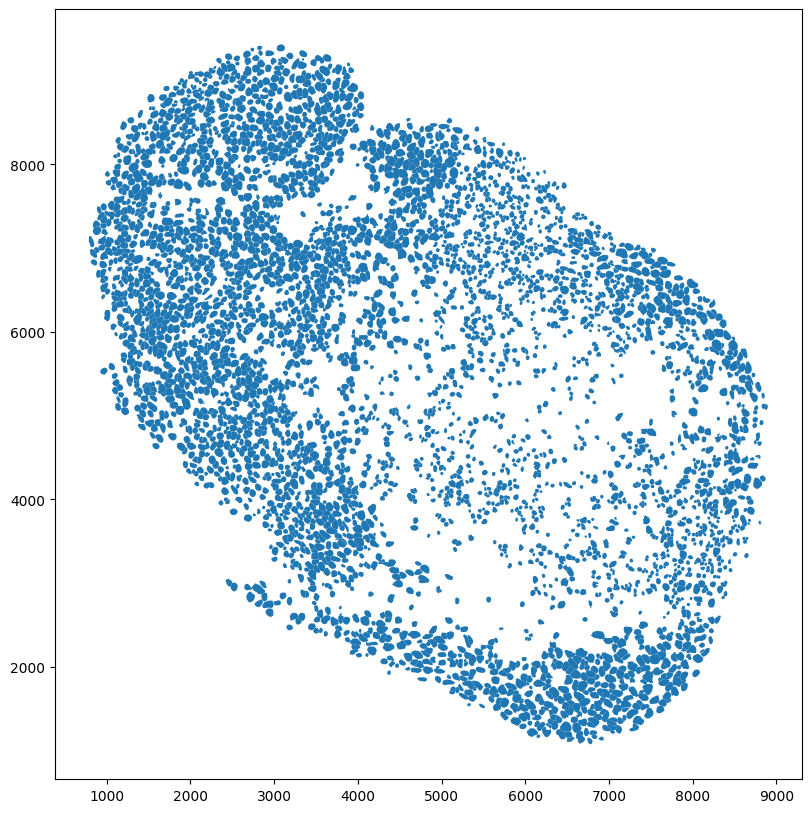

In [4]:
sg_obj3.gdf.plot(figsize=(10, 10))
plt.show()

Dilation completed. Output column: 'nucleus_dilated' is now the active geometry column.


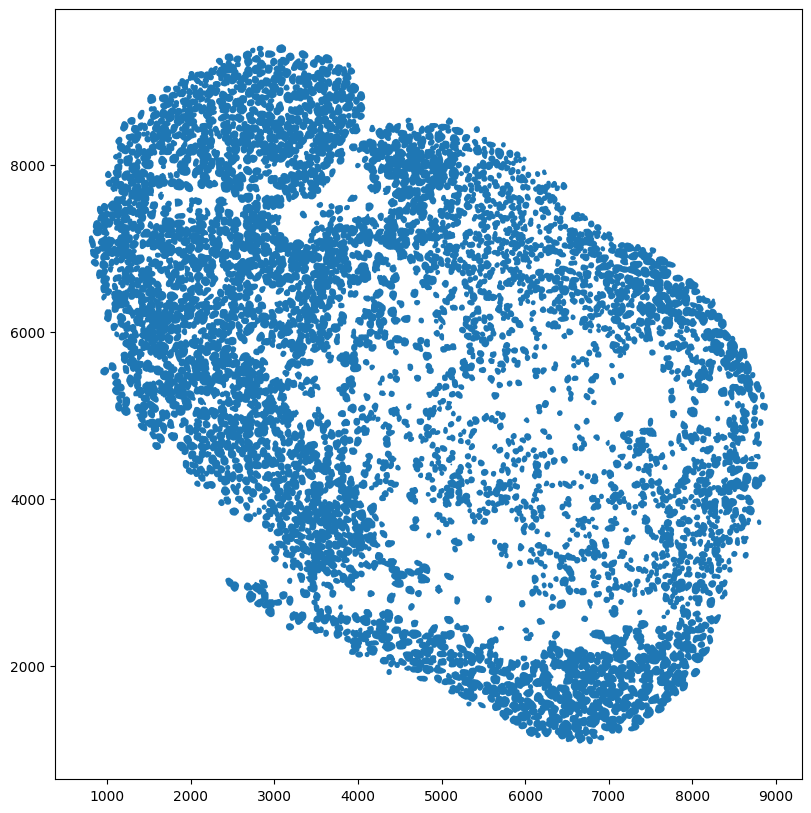

                  object_id  \
0  65d3a2a53f73fc2469cc3ab5   
1  65d3a2a53f73fc2469cc3ab6   
2  65d3a2a53f73fc2469cc3ab7   
3  65d3a2a53f73fc2469cc3ab8   
4  65d3a2a53f73fc2469cc3ab9   

                                             nucleus  \
0  POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1  POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2  POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3  POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4  POLYGON ((4837.000 1911.000, 4815.000 1917.000...   

                                     nucleus_dilated  
0  POLYGON ((4974.169 1792.238, 4973.176 1792.069...  
1  POLYGON ((4789.555 1813.015, 4788.591 1813.008...  
2  POLYGON ((5116.247 1846.191, 5115.405 1845.587...  
3  POLYGON ((4370.290 1893.266, 4369.324 1893.088...  
4  POLYGON ((4838.322 1901.088, 4837.328 1901.005...  


In [4]:
sg_obj3.dilate_objects(10)
sg_obj3.gdf.plot(figsize=(10, 10))
plt.show()
print(sg_obj3.gdf.head())

In [5]:
spot_file = '/Users/arjunraj/code/convert_masks_SG/test.csv'

sg_obj3.load_points(spot_file)
sg_obj3.create_cell_gene_table()
cell_gene_df = sg_obj3.get_cell_gene_table_df()
print(cell_gene_df.head())

428559 of 841314 spots (50.9%) assigned to an object.
name                      Abca7  Aldh1a2  Apoe  Atad2  Atm  Aurkb  Bad  Bax  \
object_id                                                                     
65d3a2a53f73fc2469cc3ab5      0        2     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab6      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab7      0        0     0      0    0      1    0    0   
65d3a2a53f73fc2469cc3ab8      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab9      0        1     1      0    0      0    0    0   

name                      Bbc3  Bcl2  ...  Ung  Utf1  Vwf  Was  Wnt3a  Wnt5a  \
object_id                             ...                                      
65d3a2a53f73fc2469cc3ab5     0     0  ...    1     0    1    0      0      0   
65d3a2a53f73fc2469cc3ab6     0     0  ...    0     0    0    0      0      0   
65d3a2a53f73fc2469cc3ab7     0     0  ...    0     0    0    0      0   

In [12]:
s_genes = [
    'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Mlf1ip',
    'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 
    'Msh2', 'Atad2'
]

g2m_genes = [
    'Hmgb2', 'Cdk1', 'Nusap1', 'Tpx2', 'Top2a', 'Nuf2', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3',
    'Fam64a', 'Smc4', 'Ccnb2', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Gtse1', 'Kif20b',
    'Hjurp', 'Cdca3', 'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2'
]

sc.tl.score_genes_cell_cycle(sg_obj3.cell_gene_table, s_genes=s_genes, g2m_genes=g2m_genes)
print(sg_obj3.cell_gene_table.obs.head())
print(sg_obj3.cell_gene_table.obs.columns.tolist())

                           S_score  G2M_score phase
object_id                                          
65d3a2a53f73fc2469cc3ab5  0.175000  -0.658921     S
65d3a2a53f73fc2469cc3ab6  0.068182  -0.404423     S
65d3a2a53f73fc2469cc3ab7 -0.177273   0.647301   G2M
65d3a2a53f73fc2469cc3ab8 -0.011364   0.034858   G2M
65d3a2a53f73fc2469cc3ab9  0.275000   1.272864   G2M
['S_score', 'G2M_score', 'phase']


In [6]:
sg_obj3.export_to_nimbus_json('/Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated.json', gene_names="Sox2")

Exported to JSON: /Users/arjunraj/code/convert_masks_SG/hyb_1_aligned_20240219-test-segmentation-dilated.json


In [8]:
cell_count_df = sg_obj3.cell_count_df
print(cell_count_df.index)

Index(['65d3a2a53f73fc2469cc3ab5', '65d3a2a53f73fc2469cc3ab6',
       '65d3a2a53f73fc2469cc3ab7', '65d3a2a53f73fc2469cc3ab8',
       '65d3a2a53f73fc2469cc3ab9', '65d3a2a53f73fc2469cc3aba',
       '65d3a2a53f73fc2469cc3abb', '65d3a2a53f73fc2469cc3abc',
       '65d3a2a53f73fc2469cc3abd', '65d3a2a53f73fc2469cc3abe',
       ...
       '65d3a5583f73fc2469cc5cb0', '65d3a5673f73fc2469cc5cb3',
       '65d3a56d3f73fc2469cc5cb6', '65d3a5703f73fc2469cc5cbb',
       '65d3a5a33f73fc2469cc5cc2', '65d3a5a73f73fc2469cc5cc5',
       '65d3a5ae3f73fc2469cc5cc8', '65d3a5b23f73fc2469cc5ccb',
       '65d3a6143f73fc2469cc5cd8', '65d3a6d83f73fc2469cc5ceb'],
      dtype='object', name='object_id', length=4288)


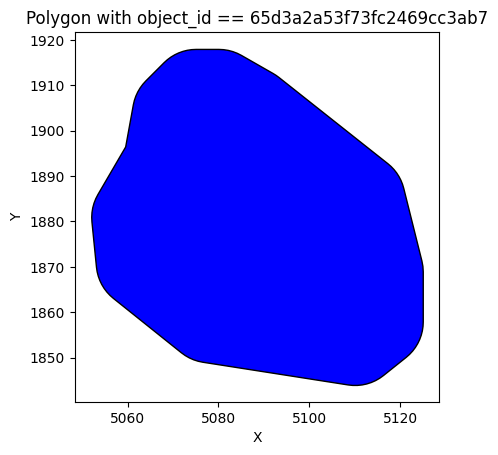

In [7]:
sg_obj3.plot_polygon_by_id("65d3a2a53f73fc2469cc3ab7")

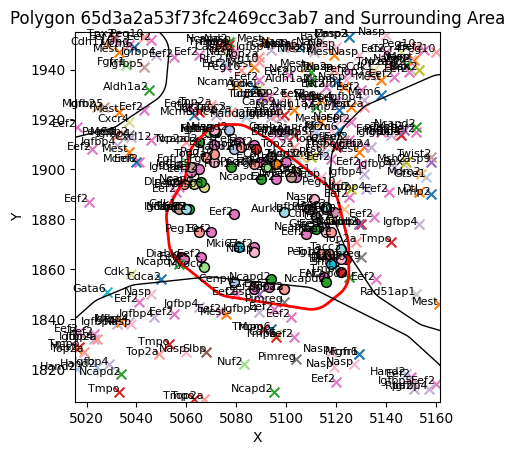

In [8]:
sg_obj3.plot_polygon_and_points("65d3a2a53f73fc2469cc3ab7")

Number of objects: 4330
Number of points: 845413
Average number of points per object: 195.25
Percentage of points assigned to an object: 50.69%
Average number of assigned points per object: 98.97
Average number of unique genes detected per object: 25.81
Total number of genes detected: 221
Total number of genes detected (assigned to objects): 221


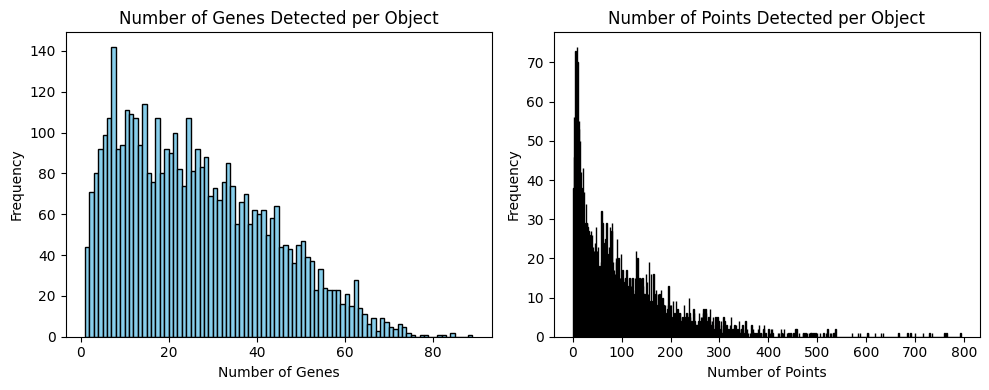

In [9]:
sg_obj3.generate_statistics_and_histograms()


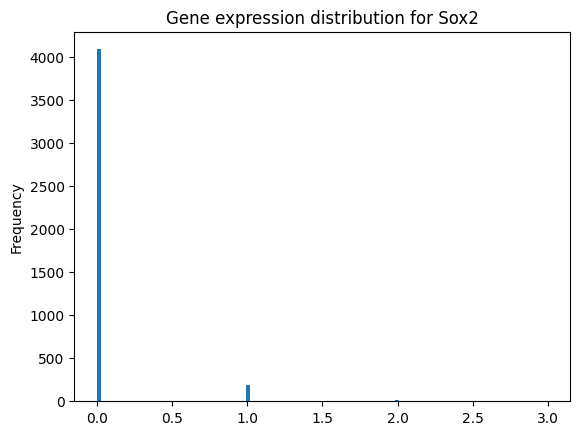

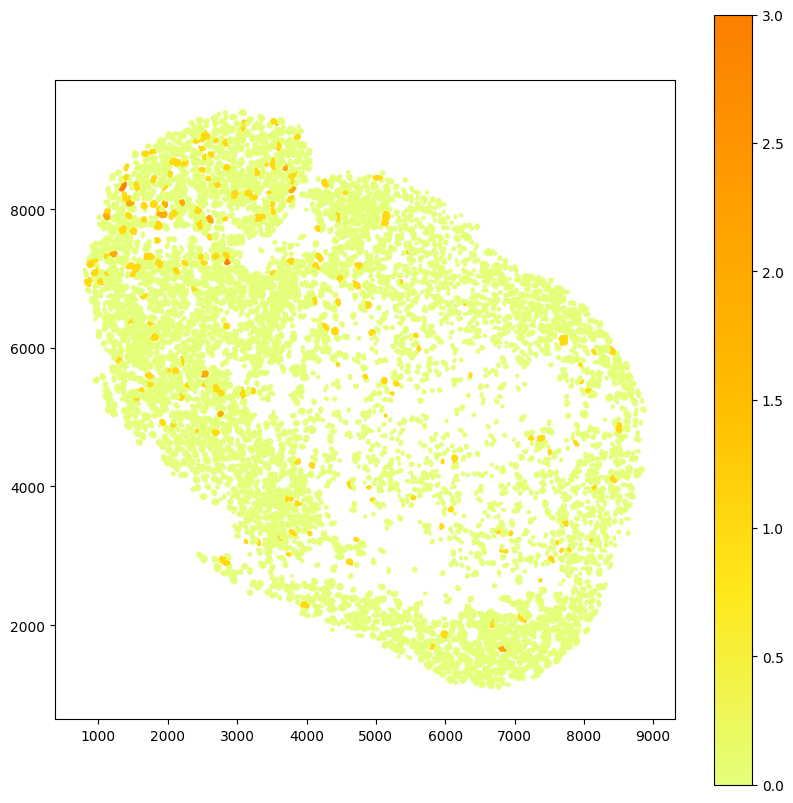

Statistics for gene Sox2: count    4288.000000
mean        0.050606
std         0.237601
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: Sox2, dtype: float64
Number of objects expressing Sox2: 201 out of 4288 (4.69%)


In [10]:
sg_obj3.show_gene_stats_plots('Sox2')

Number of objects: 4330
Number of points: 845413
Average number of points per object: 195.25
Percentage of points assigned to an object: 50.69%
Average number of assigned points per object: 98.97
Average number of unique genes detected per object: 25.81
Total number of genes detected: 221
Total number of genes detected (assigned to objects): 221


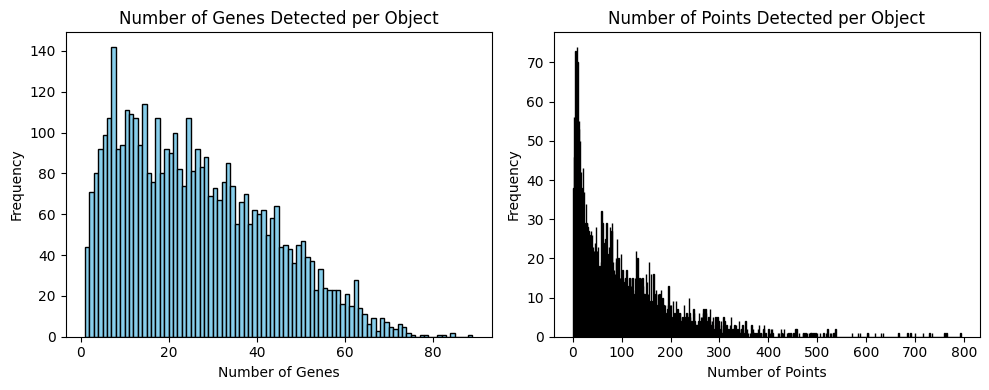

In [9]:
sg_obj3.generate_statistics_and_histograms()

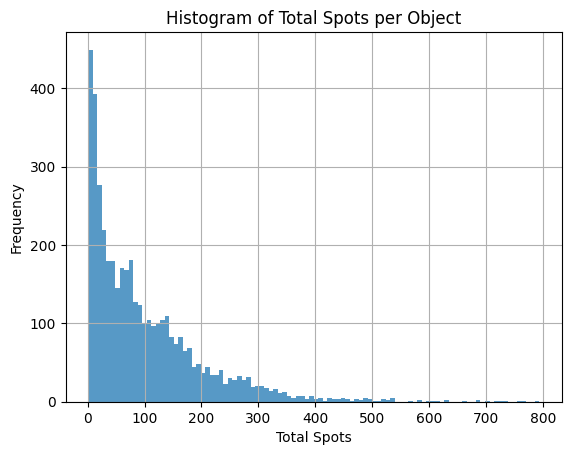

In [8]:
pivot_table = sg_obj3.cell_count_df

# Sum across the gene columns for each object to get total spots per object
total_spots_per_object = pivot_table.sum(axis=1)

# Plot histogram
total_spots_per_object.hist(bins=100, alpha=0.75)
plt.title('Histogram of total spot count per object')
plt.xlabel('Total spot count')
plt.ylabel('Frequency')
plt.show()


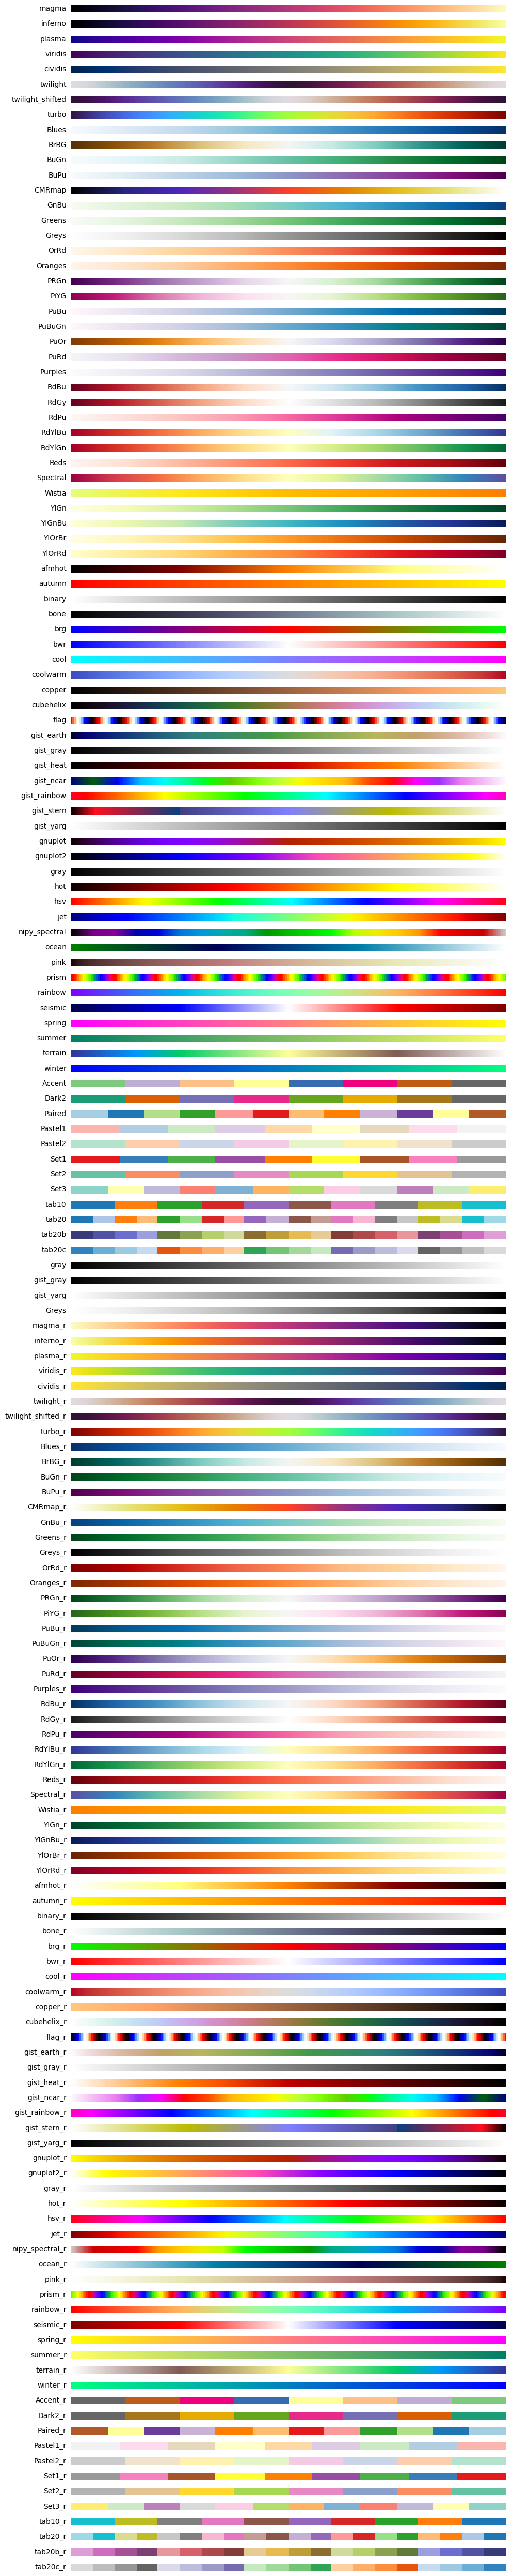

In [21]:
import matplotlib.pyplot as plt

# Display a selection of colormaps
fig, axs = plt.subplots(nrows=len(plt.colormaps()), figsize=(10, 50))
for ax, cmap in zip(axs, plt.colormaps()):
    cmap = plt.get_cmap(cmap)
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.text(-.01, .5, cmap.name, va='center', ha='right', fontsize=10, transform=ax.transAxes)
    ax.set_axis_off()

plt.tight_layout()
plt.show()


                  object_id  \
0  65d3a2a53f73fc2469cc3ab5   
1  65d3a2a53f73fc2469cc3ab6   
2  65d3a2a53f73fc2469cc3ab7   
3  65d3a2a53f73fc2469cc3ab8   
4  65d3a2a53f73fc2469cc3ab9   

                                             nucleus  \
0  POLYGON ((4972.000 1802.000, 4936.000 1826.000...   
1  POLYGON ((4789.000 1823.000, 4768.000 1828.000...   
2  POLYGON ((5110.000 1854.000, 5078.000 1859.000...   
3  POLYGON ((4368.000 1903.000, 4360.000 1906.000...   
4  POLYGON ((4837.000 1911.000, 4815.000 1917.000...   

                                     nucleus_dilated  Abca7  Aldh1a2  Apoe  \
0  POLYGON ((4974.169 1792.238, 4973.176 1792.069...    0.0      2.0   0.0   
1  POLYGON ((4789.555 1813.015, 4788.591 1813.008...    0.0      0.0   0.0   
2  POLYGON ((5116.247 1846.191, 5115.405 1845.587...    0.0      0.0   0.0   
3  POLYGON ((4370.290 1893.266, 4369.324 1893.088...    0.0      0.0   0.0   
4  POLYGON ((4838.322 1901.088, 4837.328 1901.005...    0.0      1.0   1.0   

   Atad

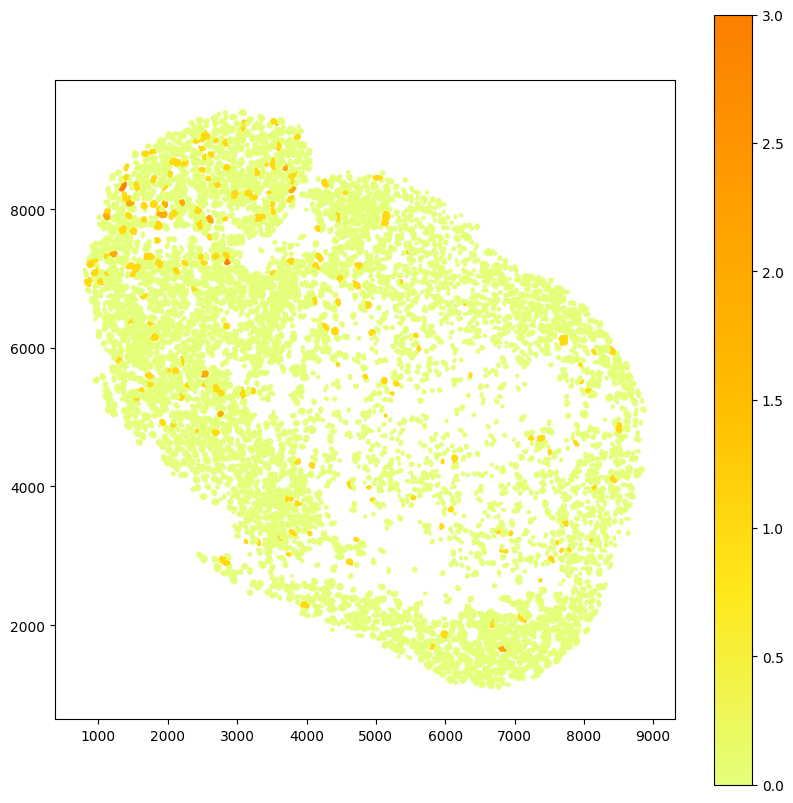

In [22]:
# sg_obj3.gdf.plot(figsize=(10, 10))
# plt.show()

merged_gdf = sg_obj3.gdf.merge(sg_obj3.cell_count_df, on='object_id', how='left')
print(merged_gdf.head())

merged_gdf.plot(column='Sox2', figsize=(10, 10), legend=True, cmap='Wistia')
plt.show()


In [8]:
spot_file = '/Users/arjunraj/code/convert_masks_SG/test.csv'

sg_obj3.load_points(spot_file)
sg_obj3.create_cell_count_df(point_assignment_mode='All')
print(sg_obj3.cell_count_df.head())

/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:144: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, usecols=['name', 'refid', 'x', 'y'])
/Users/arjunraj/miniconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


817601 of 1114155 spots (73.4%) assigned to an object.
name                      Abca7  Aldh1a2  Apoe  Atad2  Atm  Aurkb  Bad  Bax  \
object_id                                                                     
65d3a2a53f73fc2469cc3ab5      0        4     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab6      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab7      0        0     0      0    0      1    0    0   
65d3a2a53f73fc2469cc3ab8      0        0     0      0    0      0    0    0   
65d3a2a53f73fc2469cc3ab9      0        6     1      0    0      0    0    1   

name                      Bbc3  Bcl2  ...  Ung  Utf1  Vwf  Was  Wnt3a  Wnt5a  \
object_id                             ...                                      
65d3a2a53f73fc2469cc3ab5     0     0  ...    1     0    1    0      0      0   
65d3a2a53f73fc2469cc3ab6     0     0  ...    0     0    0    0      0      0   
65d3a2a53f73fc2469cc3ab7     0     0  ...    0     0    0    0      0  

/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:297: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(exterior_points.geometry.x, exterior_points.geometry.y, marker='x', s=50, edgecolor='black', color=color_map[name])
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:297: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(exterior_points.geometry.x, exterior_points.geometry.y, marker='x', s=50, edgecolor='black', color=color_map[name])
/Users/arjunraj/code/SGanalysis/SGanalysis/SGobject.py:297: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chang

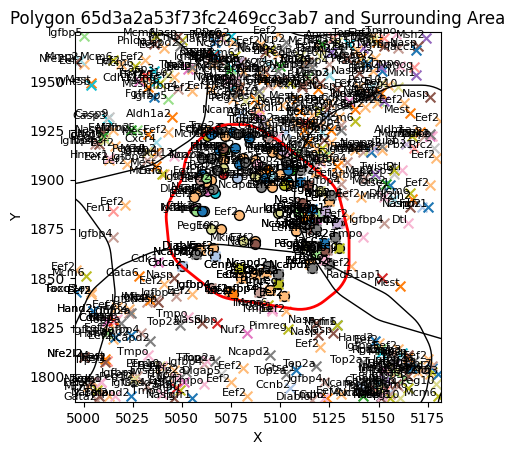

In [9]:
sg_obj3.plot_polygon_and_points("65d3a2a53f73fc2469cc3ab7")

In [12]:
import geopandas as gpd
import pandas as pd


points_gdf = sg_obj3.points_gdf
gdf = sg_obj3.gdf
assigned_points_gdf = sg_obj3.assigned_points_gdf


def distance_to_polygon_edge(point, polygon):
    # Check if polygon is None before attempting to access its boundary
    if polygon is None:
        return None
    # If polygon is not None, proceed to calculate the distance
    return point.distance(polygon.boundary)


points_in_polygons = gpd.sjoin(points_gdf, gdf, how='left', op='within')


#print(points_in_polygons.head())

points_in_polygons['distance_to_edge'] = points_in_polygons.apply(
    lambda row: distance_to_polygon_edge(
        row.geometry, 
        # Use None if 'index_right' is nan; otherwise, get the polygon geometry
        gdf.geometry.loc[row['index_right']] if not pd.isna(row['index_right']) else None
    ), 
    axis=1
)

print(points_in_polygons.head())


# Group by point index (assuming the index of points_gdf uniquely identifies each point)
# and count the number of polygons associated with each point
counts = points_in_polygons.groupby(points_in_polygons.index).size()

# Filter to find points associated with more than one polygon
multi_poly_points = counts[counts > 1]

# Calculate the absolute number and fraction of points in multiple polygons
num_multi_poly_points = len(multi_poly_points)
total_points = len(points_gdf)
fraction_multi_poly_points = num_multi_poly_points / total_points

print(f"Number of points in multiple polygons: {num_multi_poly_points}")
print(f"Fraction of points in multiple polygons: {fraction_multi_poly_points:.2f}")



/Users/arjunraj/miniconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


   name               refid     x     y                   geometry  \
0  Tcf3  ENSMUSG00000020167  6122  1219  POINT (6122.000 1219.000)   
1  Tcf3  ENSMUSG00000020167  6129  1187  POINT (6129.000 1187.000)   
2  Tcf3  ENSMUSG00000020167  6192  1272  POINT (6192.000 1272.000)   
3  Tcf3  ENSMUSG00000020167  6374  1244  POINT (6374.000 1244.000)   
4  Tcf3  ENSMUSG00000020167  6344  1232  POINT (6344.000 1232.000)   

   index_right                 object_id  \
0       4200.0  65d3a2a83f73fc2469cc4b2c   
1       4200.0  65d3a2a83f73fc2469cc4b2c   
2       4201.0  65d3a2a83f73fc2469cc4b2d   
3       3583.0  65d3a2a83f73fc2469cc48bb   
4          NaN                       NaN   

                                             nucleus  distance_to_edge  
0  POLYGON ((6073.000 1163.000, 6045.000 1174.000...         32.342077  
1  POLYGON ((6073.000 1163.000, 6045.000 1174.000...         12.029295  
2  POLYGON ((6163.000 1232.000, 6147.000 1243.000...         25.858788  
3  POLYGON ((6436.000 

In [5]:

# Save the GeoDataFrame as a GeoJSON file
print("Running save_polygons")
sg_obj.save_geojson_polygons('output_polygons.geojson')


Running save_polygons


In [ ]:

# Load polygons from a GeoJSON file (optional)
print("Running load_polygons")
sg_obj.load_geojson_polygons('output_polygons.geojson')


In [4]:

# Access the GeoDataFrame
print(sg_obj.gdf.head())

print("Column names:", sg_obj.gdf.columns)


   cell_id                                            nucleus
0     28.0  POLYGON ((17398.000 4.000, 17435.000 6.000, 17...
1     18.0  POLYGON ((31940.000 2.000, 31947.000 2.000, 31...
2      9.0  POLYGON ((31469.000 0.000, 31496.000 4.000, 31...
3     23.0  POLYGON ((14591.000 3.000, 14628.000 6.000, 14...
4      1.0  POLYGON ((9.000 0.000, 45.000 0.000, 45.000 2....
Column names: Index(['cell_id', 'nucleus'], dtype='object')
